### CNN Model

### Import libraries & packages

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Input, Embedding, Conv1D, GlobalMaxPooling1D, Flatten, concatenate, Dense, Dropout, Lambda
from keras.metrics import Precision, Recall, AUC
from keras.callbacks import EarlyStopping, ModelCheckpoint

import tensorflow as tf 
from tensorflow.keras.models import Model,load_model
from tensorflow.keras.optimizers import Adam, SGD

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

In [ ]:
%cd /content/drive/My Drive/BT4222/Final/datasets

In [ ]:
df = pd.read_csv('masterdata.csv')

In [ ]:
df = df.drop(columns = ['category', 'label', 'text_', 'lang', 'cleaned_text'])

In [ ]:
from sklearn.model_selection import train_test_split

X=df.drop('target', axis=1)
y=df.target.values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True)

### Testing Embedding Methods

### Tokenise

In [ ]:
from keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X_train['clean_text'])

X_train_text = tokenizer.texts_to_sequences(X_train['clean_text'])
X_test_text = tokenizer.texts_to_sequences(X_test['clean_text'])

vocab_size = len(tokenizer.word_index) + 1  # Adding 1 because of reserved 0 index

In [ ]:
from keras.preprocessing.sequence import pad_sequences

maxlen = 100

X_train_text = pad_sequences(X_train_text, padding='post', maxlen=maxlen)
X_test_text = pad_sequences(X_test_text, padding='post', maxlen=maxlen)

In [ ]:
# Concat tokenized array back to numerical columns in original X_train
X_train_num = X_train.drop(columns=['clean_text']) # drop the original clean_text textual data
X_test_num = X_test.drop(columns=['clean_text'])

### Word Embedding 

In [ ]:
embedding_dim = 50

text_input = Input(shape = (maxlen,))
num_input = Input(shape = X_train_num.shape[1:])
emb = (Embedding(input_dim=vocab_size, 
                output_dim=embedding_dim, 
                input_length=maxlen,
                trainable=True))(text_input)

text_output = Conv1D(128, 3)(emb)
text_output = GlobalMaxPooling1D()(text_output)
concat = concatenate([text_output, num_input])

classifier = Dense(128, activation='relu')(concat)
hidden = Dense(64, activation='relu')(classifier)
output = Dense(1, activation='sigmoid')(hidden)

CNN = Model(inputs=[text_input, num_input], outputs=[output])
CNN.compile(optimizer=Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy', AUC(name='auc'), Precision(name='precision') , Recall(name='recall')])
CNN.summary()

callbacks = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=3)

history = CNN.fit([X_train_text,X_train_num], y_train,
                    epochs=10,
                    verbose=2,
                    validation_split = 0.2,
                    batch_size=32,
                 callbacks = callbacks)

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 100)]        0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 100, 50)      1897550     input_1[0][0]                    
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 98, 128)      19328       embedding[0][0]                  
__________________________________________________________________________________________________
global_max_pooling1d (GlobalMax (None, 128)          0           conv1d[0][0]                     
______________________________________________________________________________________________

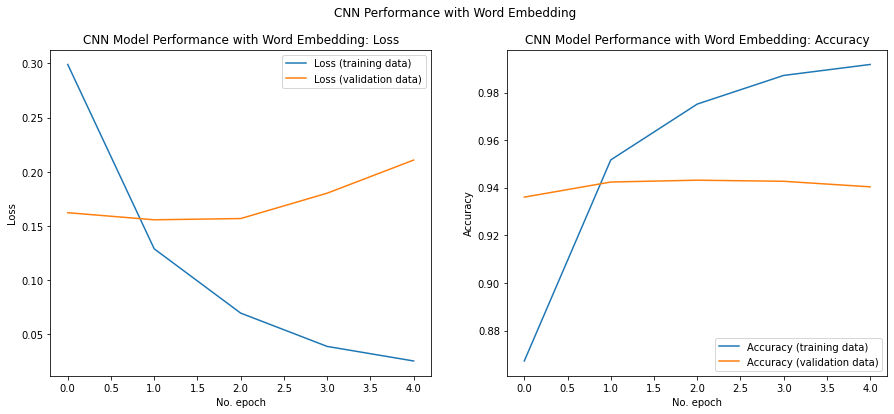

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
fig.suptitle('CNN Performance with Word Embedding')

ax1.plot(history.history['loss'], label='Loss (training data)')
ax1.plot(history.history['val_loss'], label='Loss (validation data)')
ax1.set_title('CNN Model Performance with Word Embedding: Loss')
ax1.set_ylabel('Loss')
ax1.set_xlabel('No. epoch')
ax1.legend(loc="upper right")

ax2.plot(history.history['accuracy'], label='Accuracy (training data)')
ax2.plot(history.history['val_accuracy'], label='Accuracy (validation data)')
ax2.set_title('CNN Model Performance with Word Embedding: Accuracy')
ax2.set_ylabel('Accuracy')
ax2.set_xlabel('No. epoch')
ax2.legend(loc="lower right")

In [ ]:
loss, accuracy, precision, recall, auc = CNN.evaluate([X_train_text, X_train_num], y_train, verbose=False)
print("Training Accuracy: {:.4f}%".format(accuracy*100))
print("Precision: {:.4f}%".format(precision*100))
print("Recall: {:.4f}%".format(recall*100))
f1 = 2*(precision*recall)/(precision+recall)
print("F1 Score: {:.4f}%".format(f1*100))
print("Area under Curve: {:.4f}%".format(auc*100))

Training Accuracy: 98.5444%
Precision: 99.6606%
Recall: 98.8895%
F1 Score: 99.2736%
Area under Curve: 98.1750%


In [ ]:
loss, accuracy, precision, recall, auc = CNN.evaluate([X_test_text, X_test_num], y_test, verbose=False)
print("Testing Accuracy:  {:.4f}%".format(accuracy*100))
print("Precisiony: {:.4f}%".format(precision*100))
print("Recall: {:.4f}%".format(recall*100))
f1 = 2*(precision*recall)/(precision+recall)
print("F1 Score: {:.4f}%".format(f1*100))
print("Area under Curve: {:.4f}%".format(auc*100))

Testing Accuracy:  93.6331%
Precisiony: 97.5758%
Recall: 94.9326%
F1 Score: 96.2360%
Area under Curve: 92.4405%


### Pre-trained Word Embedding

In [ ]:
import numpy as np

def create_embedding_matrix(filepath, word_index, embedding_dim):
    vocab_size = len(word_index) + 1  # Adding again 1 because of reserved 0 index
    embedding_matrix = np.zeros((vocab_size, embedding_dim))

    with open(filepath, encoding="utf8") as f:
        for line in f:
            word, *vector = line.split()
            if word in word_index:
                idx = word_index[word] 
                embedding_matrix[idx] = np.array(
                    vector, dtype=np.float32)[:embedding_dim]

    return embedding_matrix

In [ ]:
embedding_dim = 50
embedding_matrix = create_embedding_matrix(
    "glove.6B.50d.txt",
    tokenizer.word_index, embedding_dim)

In [ ]:
pd.DataFrame(embedding_matrix)

,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
0,0.00000,0.00000,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000,0.000000,0.000000,...,0.000000,0.000000,0.00000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.00000
1,0.41800,0.24968,-0.412420,0.121700,0.345270,-0.044457,-0.49688,-0.17862,-0.000660,-0.656600,...,-0.298710,-0.157490,-0.34758,-0.045637,-0.442510,0.18785,0.002785,-0.184110,-0.115140,-0.78581
2,0.11891,0.15255,-0.082073,-0.741440,0.759170,-0.483280,-0.31009,0.51476,-0.987080,0.000618,...,-0.002744,-0.018298,-0.28096,0.553180,0.037706,0.18555,-0.150250,-0.575120,-0.266710,0.92121
3,0.21705,0.46515,-0.467570,0.100820,1.013500,0.748450,-0.53104,-0.26256,0.168120,0.131820,...,0.138130,0.369730,-0.64289,0.024142,-0.039315,-0.26037,0.120170,-0.043782,0.410130,0.17960
4,0.26818,0.14346,-0.278770,0.016257,0.113840,0.699230,-0.51332,-0.47368,-0.330750,-0.138340,...,-0.069043,0.368850,0.25168,-0.245170,0.253810,0.13670,-0.311780,-0.632100,-0.250280,-0.38097
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37946,-0.46744,-0.65538,-0.608320,-0.783800,0.950820,-0.557910,1.09400,0.54433,0.154140,-0.231370,...,0.414180,-0.611390,-0.53670,0.727200,-0.419880,-0.67189,0.568880,-0.046315,0.055176,-0.15409
37947,-0.53812,-1.44710,0.208360,-0.087029,0.260120,-0.023689,-0.39934,-0.71279,0.694600,0.550370,...,-0.287590,-0.169440,-0.36816,-0.005660,0.716510,0.12996,-0.158980,0.556790,0.667640,0.38654
37948,0.27084,-0.90812,0.494780,-0.363130,0.070722,0.144910,-0.56336,-0.34410,-0.030068,0.168810,...,-0.026266,-1.155500,0.22136,1.308400,-0.488940,-0.60547,-0.173370,0.481270,0.247670,-0.69873
37949,-0.12824,-0.19226,-0.139260,-0.535470,0.725320,0.826490,0.60030,0.54209,-0.165520,0.577400,...,0.380170,-0.096930,-0.51676,-0.032046,-0.070303,-0.16676,0.264710,0.258800,0.342000,-0.29242


In [ ]:
nonzero_elements = np.count_nonzero(np.count_nonzero(embedding_matrix, axis=1))
nonzero_elements / vocab_size

0.8131801533556428

In [ ]:
embedding_dim = 50

text_input = Input(shape = (maxlen,))
num_input = Input(shape = X_train_num.shape[1:])
emb = (Embedding(input_dim=vocab_size, 
                output_dim=embedding_dim, 
                weights=[embedding_matrix], 
                input_length=maxlen,
                trainable=True))(text_input)

text_output = Conv1D(128, 3)(emb)
text_output = GlobalMaxPooling1D()(text_output)
concat = concatenate([text_output, num_input])

classifier = Dense(128, activation='relu')(concat)
hidden = Dense(64, activation='relu')(classifier)
output = Dense(1, activation='sigmoid')(hidden)

CNN = Model(inputs=[text_input, num_input], outputs=[output])
CNN.compile(optimizer=Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy', AUC(name='auc'), Precision(name='precision') , Recall(name='recall')])
CNN.summary()

callbacks = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=3)

history = CNN.fit([X_train_text,X_train_num], y_train,
                    epochs=10,
                    verbose=2,
                    validation_split=0.2,
                    batch_size=32,
                 callbacks = callbacks)

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 100)]        0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 100, 50)      1897550     input_3[0][0]                    
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 98, 128)      19328       embedding_1[0][0]                
__________________________________________________________________________________________________
global_max_pooling1d_1 (GlobalM (None, 128)          0           conv1d_1[0][0]                   
____________________________________________________________________________________________

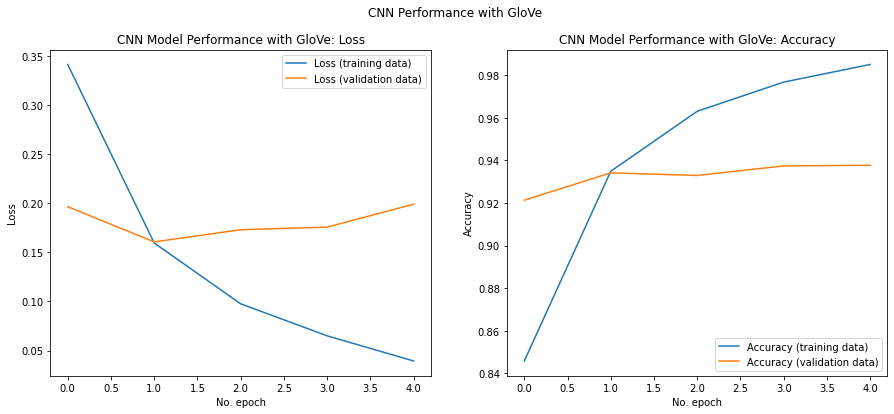

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
fig.suptitle('CNN Performance with GloVe')

ax1.plot(history.history['loss'], label='Loss (training data)')
ax1.plot(history.history['val_loss'], label='Loss (validation data)')
ax1.set_title('CNN Model Performance with GloVe: Loss')
ax1.set_ylabel('Loss')
ax1.set_xlabel('No. epoch')
ax1.legend(loc="upper right")

ax2.plot(history.history['accuracy'], label='Accuracy (training data)')
ax2.plot(history.history['val_accuracy'], label='Accuracy (validation data)')
ax2.set_title('CNN Model Performance with GloVe: Accuracy')
ax2.set_ylabel('Accuracy')
ax2.set_xlabel('No. epoch')
ax2.legend(loc="lower right")

In [ ]:
loss, accuracy, precision, recall, auc = CNN.evaluate([X_train_text, X_train_num], y_train, verbose=False)
print("Training Accuracy: {:.4f}%".format(accuracy*100))
print("Precision: {:.4f}%".format(precision*100))
print("Recall: {:.4f}%".format(recall*100))
f1 = 2*(precision*recall)/(precision+recall)
print("F1 Score: {:.4f}%".format(f1*100))
print("Area under Curve: {:.4f}%".format(auc*100))

Training Accuracy: 98.3864%
Precision: 99.7002%
Recall: 98.4408%
F1 Score: 99.0665%
Area under Curve: 98.3121%


In [ ]:
loss, accuracy, precision, recall, auc = CNN.evaluate([X_test_text, X_test_num], y_test, verbose=False)
print("Testing Accuracy:  {:.4f}%".format(accuracy*100))
print("Precisiony: {:.4f}%".format(precision*100))
print("Recall: {:.4f}%".format(recall*100))
f1 = 2*(precision*recall)/(precision+recall)
print("F1 Score: {:.4f}%".format(f1*100))
print("Area under Curve: {:.4f}%".format(auc*100))

Testing Accuracy:  93.6703%
Precisiony: 97.8671%
Recall: 93.8428%
F1 Score: 95.8127%
Area under Curve: 93.7287%


### Hyperparameter Tuning

### Hyperparameter Tuning using RandomisedSearchCV

In [ ]:
import numpy as np

def create_embedding_matrix(filepath, word_index, embedding_dim):
    vocab_size = len(word_index) + 1  # Adding again 1 because of reserved 0 index
    embedding_matrix = np.zeros((vocab_size, embedding_dim))

    with open(filepath, encoding="utf8") as f:
        for line in f:
            word, *vector = line.split()
            if word in word_index:
                idx = word_index[word] 
                embedding_matrix[idx] = np.array(
                    vector, dtype=np.float32)[:embedding_dim]

    return embedding_matrix

In [ ]:
def create_model(kernel_size, vocab_size, emb_dim, hidden_units, dropout_rate, learning_rate):
    maxlen =100
    if emb_dim == 50:
        emb_matrix = create_embedding_matrix("glove.6B.50d.txt", tokenizer.word_index, emb_dim)
    elif emb_dim == 100:
        emb_matrix = create_embedding_matrix("glove.6B.100d.txt", tokenizer.word_index, emb_dim)
    else:
        emb_matrix = create_embedding_matrix("glove.6B.200d.txt", tokenizer.word_index, emb_dim)
    
    combi_input = Input((113,))
    text_input = Lambda(lambda x: x[:, :maxlen])(combi_input)
    num_input = Lambda(lambda x: x[:, maxlen:])(combi_input)
    emb = (Embedding(input_dim=vocab_size, 
                    output_dim=emb_dim, 
                    weights=[emb_matrix], 
                    input_length=100,
                    trainable=True))(text_input)

    text_output = Conv1D(128, kernel_size)(emb)
    text_output = GlobalMaxPooling1D()(text_output)
    concat = concatenate([text_output, num_input])
    
    dropout1 = Dropout(dropout_rate)(concat)
    dense1 = Dense(hidden_units, activation='relu')(dropout1)
    dropout2 = Dropout(dropout_rate)(dense1)
    dense2 = Dense(hidden_units/2, activation='relu')(dropout2)                     
    dropout3 = Dropout(dropout_rate)(dense2)     
    output = Dense(1, activation='sigmoid')(dropout3)

    CNN = Model(inputs=[combi_input], outputs=[output])
    CNN.compile(loss='binary_crossentropy',
                optimizer=Adam(learning_rate),
                metrics=['accuracy', AUC(name='auc'), Precision(name='precision') , Recall(name='recall')])
    CNN.summary()
    return CNN

In [ ]:
param_grid = dict(kernel_size=[3, 5, 7],
                  vocab_size=[vocab_size], 
                  emb_dim=[50,100,200],
                  hidden_units=[32, 64, 128],
                  dropout_rate=[0.2, 0.3, 0.4],
                  learning_rate=[0.001,0.01],
                  batch_size=[32,64,128])

In [ ]:
#creates model callback to stop model if val loss does not decrease for more than 5 consecutive epochs
es = EarlyStopping(monitor='val_loss', 
                   mode='min', 
                   verbose=2, 
                   patience=5)

#creates model callback to save model with the lowest val loss
mc = ModelCheckpoint('best_CNN.h5', 
                     monitor='val_loss',
                     mode='min',
                     verbose=2, 
                     save_best_only=True)
callbacks = [es, mc]

In [ ]:
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import RandomizedSearchCV

CNN = KerasClassifier(create_model, epochs=50)

grid = RandomizedSearchCV(CNN, param_grid, n_jobs=-1, cv=3)

In [ ]:
X_train_concat = np.hstack((X_train_text, X_train_num.to_numpy()))
X_test_concat = np.hstack((X_test_text, X_test_num.to_numpy()))

In [ ]:
grid_result = grid.fit(X_train_concat, y_train,
                        verbose=2,
                        validation_split=0.2,
                      callbacks = es)

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 113)]        0                                            
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 100)          0           input_1[0][0]                    
__________________________________________________________________________________________________
embedding (Embedding)           (None, 100, 100)     3749500     lambda[0][0]                     
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 94, 128)      89728       embedding[0][0]                  
______________________________________________________________________________________________

In [ ]:
pd.DataFrame(grid_result.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_vocab_size,param_learning_rate,param_kernel_size,param_hidden_units,param_emb_dim,param_dropout_rate,param_batch_size,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,1665.590794,58.609882,38.514882,7.259304,37495,0.001,5,128,200,0.2,64,"{'vocab_size': 37495, 'learning_rate': 0.001, ...",0.930688,0.934777,0.927065,0.930843,0.003150,3
1,1227.737838,164.141559,35.409544,15.302309,37495,0.001,7,32,100,0.3,64,"{'vocab_size': 37495, 'learning_rate': 0.001, ...",0.930410,0.935427,0.928737,0.931525,0.002843,1
2,951.337469,24.994871,18.432043,0.274224,37495,0.01,3,64,200,0.3,128,"{'vocab_size': 37495, 'learning_rate': 0.01, '...",0.909505,0.914522,0.895196,0.906408,0.008188,7
3,503.596349,7.446845,23.575457,5.025386,37495,0.01,5,128,50,0.3,64,"{'vocab_size': 37495, 'learning_rate': 0.01, '...",0.910155,0.917031,0.887020,0.904735,0.012837,9
4,2284.282036,190.533590,67.620986,18.226322,37495,0.01,5,128,200,0.2,32,"{'vocab_size': 37495, 'learning_rate': 0.01, '...",0.908854,0.892967,0.913314,0.905045,0.008733,8
5,661.525904,32.433585,39.188897,5.349632,37495,0.01,7,128,50,0.3,32,"{'vocab_size': 37495, 'learning_rate': 0.01, '...",0.888042,0.905417,0.907275,0.900245,0.008662,10
6,380.885580,30.908037,10.879769,0.889672,37495,0.01,3,64,50,0.2,128,"{'vocab_size': 37495, 'learning_rate': 0.01, '...",0.913035,0.912571,0.912385,0.912664,0.000274,5
7,1482.698337,13.841622,42.416648,15.304465,37495,0.01,7,64,200,0.2,64,"{'vocab_size': 37495, 'learning_rate': 0.01, '...",0.873270,0.920561,0.927251,0.907027,0.024026,6
8,443.167835,52.322633,14.049381,3.628433,37495,0.01,7,128,50,0.2,128,"{'vocab_size': 37495, 'learning_rate': 0.01, '...",0.924742,0.917588,0.927344,0.923225,0.004125,4
9,1332.105726,201.834644,23.329067,23.130401,37495,0.001,5,128,200,0.3,32,"{'vocab_size': 37495, 'learning_rate': 0.001, ...",0.929109,0.932361,0.931246,0.930905,0.001349,2


In [ ]:
test_accuracy = grid_result.score(X_test_concat, y_test)

127/127 [==============================] - 2s 18ms/step - loss: 0.2383 - accuracy: 0.9424 - auc: 0.9784 - precision: 0.9526 - recall: 0.9317


In [ ]:
print('Best Score: %s' % grid_result.best_score_)
print('Best Hyperparameters: %s' % grid_result.best_params_)

Best Score: 0.9315246740976969
Best Hyperparameters: {'vocab_size': 37495, 'learning_rate': 0.001, 'kernel_size': 7, 'hidden_units': 32, 'emb_dim': 100, 'dropout_rate': 0.3, 'batch_size': 64}


Best Model

In [ ]:
emb_matrix = create_embedding_matrix("glove.6B.100d.txt", tokenizer.word_index, 100)

combi_input = Input((113,))
text_input = Lambda(lambda x: x[:, :100])(combi_input)
num_input = Lambda(lambda x: x[:, 100:])(combi_input)
emb = (Embedding(input_dim=vocab_size, 
                output_dim=100, 
                weights=[emb_matrix], 
                input_length=100,
                trainable=True))(text_input)

text_output = Conv1D(128, 7)(emb)
text_output = GlobalMaxPooling1D()(text_output)
concat = concatenate([text_output, num_input])

dropout1 = Dropout(0.3)(concat)
dense1 = Dense(32, activation='relu')(dropout1)
dropout2 = Dropout(0.3)(dense1)
dense2 = Dense(16, activation='relu')(dropout2)                     
dropout3 = Dropout(0.3)(dense2)     
output = Dense(1, activation='sigmoid')(dropout3)

CNN = Model(inputs=[combi_input], outputs=[output])
CNN.compile(loss='binary_crossentropy',
            optimizer=Adam(0.001),
            metrics=['accuracy', AUC(name='auc'), Precision(name='precision') , Recall(name='recall')])
CNN.summary()

es = EarlyStopping(monitor='val_loss', 
               mode='min', 
               patience=10)

mc = ModelCheckpoint('best_CNN_model.hdf5', 
                 monitor='val_loss',
                 mode='min',
                 verbose=1, 
                 save_best_only=True)
callbacks = [es, mc]

history = CNN.fit(X_train_concat, y_train,
                    epochs=50,
                    verbose=2,
                    validation_split=0.2,
                    batch_size=64,
                 callbacks = callbacks)

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 113)]        0                                            
__________________________________________________________________________________________________
lambda_2 (Lambda)               (None, 100)          0           input_2[0][0]                    
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 100, 100)     3749500     lambda_2[0][0]                   
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 94, 128)      89728       embedding_1[0][0]                
____________________________________________________________________________________________

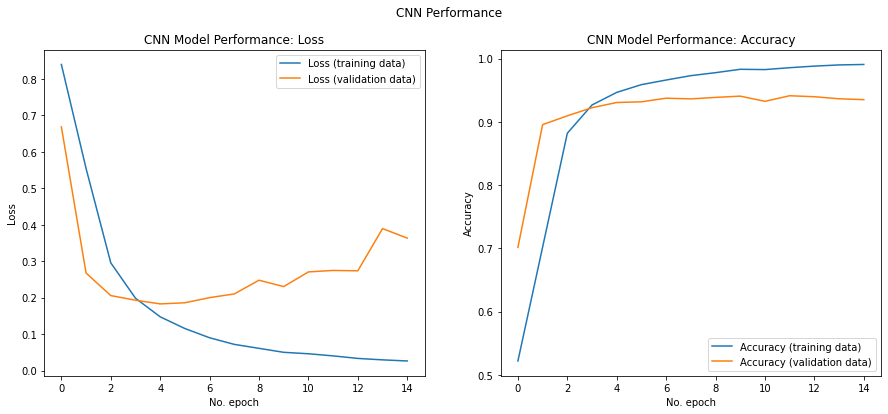

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
fig.suptitle('CNN Performance')

ax1.plot(history.history['loss'], label='Loss (training data)')
ax1.plot(history.history['val_loss'], label='Loss (validation data)')
ax1.set_title('CNN Model Performance: Loss')
ax1.set_ylabel('Loss')
ax1.set_xlabel('No. epoch')
ax1.legend(loc="upper right")

ax2.plot(history.history['accuracy'], label='Accuracy (training data)')
ax2.plot(history.history['val_accuracy'], label='Accuracy (validation data)')
ax2.set_title('CNN Model Performance: Accuracy')
ax2.set_ylabel('Accuracy')
ax2.set_xlabel('No. epoch')
ax2.legend(loc="lower right")

In [ ]:
model = load_model('best_CNN_model.hdf5')

loss, accuracy, precision, recall, auc = model.evaluate(X_test_concat, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}%".format(accuracy*100))
print("Precisiony: {:.4f}%".format(precision*100))
print("Recall: {:.4f}%".format(recall*100))
f1 = 2*(precision*recall)/(precision+recall)
print("F1 Score: {:.4f}%".format(f1*100))
print("Area under Curve: {:.4f}%".format(auc*100))

Testing Accuracy:  93.4225%
Precisiony: 98.2352%
Recall: 95.2932%
F1 Score: 96.7418%
Area under Curve: 91.4138%
